In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Load Excel data
file_path = r'/content/Data of Malaria (THESIS) 17 april.xlsx'
sheet_name = 'Form responses 1'

#read the data
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Define relevant practices
practices = [
    'Eliminating standing water',
    'Maintaining drainage systems used to direct water away from homes',
    'Mowing grass around the house',
    'Covering water storage containers',
    'Managing trash cans',
    'Sweeping the yard'
]

# Engagement scoring
def engaged(x):
    if pd.isna(x):
        return 0
    return 1 if str(x).strip().lower() in ['weekly', 'daily'] else 0

for practice in practices:
    df[practice + '_engaged'] = df[practice].apply(engaged)

df['Engagement_Score'] = df[[p + '_engaged' for p in practices]].sum(axis=1)
df['High_Engagement'] = df['Engagement_Score'].apply(lambda x: 1 if x >= 3 else 0)

# Predictor preparation
def yes_no_binary(x):
    if pd.isna(x):
        return 0
    return 1 if str(x).strip().lower() == 'yes' else 0

df['Higher_Education'] = df['Level of education'].apply(lambda x: 1 if str(x).strip().lower() == 'higher education' else 0)
df['Employed'] = df['Occupation'].apply(lambda x: 1 if str(x).strip().lower() == 'employed' else 0)
df['Challenges_Faced'] = df['Presence of challenges in maintaining practices'].apply(yes_no_binary)
df['Community_Engagement'] = df['Community engagement in control of mosquito breeding sites'].apply(yes_no_binary)
df['Malaria_History'] = df['History of malaria in the past year in the household'].apply(yes_no_binary)
df['Area_Residence'] = df['Area of residence'].apply(lambda x: 1 if str(x).strip().lower() == 'urban area' else 0)
df['Malaria_Cases'] = pd.to_numeric(df['Cases of malaria in the past year'], errors='coerce').fillna(0)

# Define outcome and predictors
outcome = 'High_Engagement'
predictors = [
    'Higher_Education', 'Employed', 'Challenges_Faced',
    'Community_Engagement', 'Malaria_History', 'Area_Residence', 'Malaria_Cases'
]

# Full model (adjusted odds ratios)
full_formula = f"{outcome} ~ " + " + ".join(predictors)
full_model = logit(formula=full_formula, data=df).fit()
print("=== Full Model (Adjusted Odds Ratios) ===")
print(np.exp(full_model.params))
print(full_model.summary())

# Simple models (unadjusted odds ratios)
print("\n=== Simple Logistic Regressions (Unadjusted Odds Ratios) ===")
simple_results = []

for predictor in predictors:
    formula = f"{outcome} ~ {predictor}"
    model = logit(formula=formula, data=df).fit(disp=False)
    coef = model.params[predictor]
    or_val = np.exp(coef)
    ci = model.conf_int().loc[predictor]
    ci_lower, ci_upper = np.exp(ci)
    pval = model.pvalues[predictor]
    simple_results.append({
        "Predictor": predictor,
        "OR": or_val,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
        "p-value": pval
    })

# Display simple model results
simple_df = pd.DataFrame(simple_results)
print(simple_df.to_string(index=False))

Optimization terminated successfully.
         Current function value: 0.614035
         Iterations 5
=== Full Model (Adjusted Odds Ratios) ===
Intercept               0.618612
Higher_Education        1.148360
Employed                0.627835
Challenges_Faced        1.127353
Community_Engagement    1.180758
Malaria_History         0.897549
Area_Residence          0.896510
Malaria_Cases           0.916036
dtype: float64
                           Logit Regression Results                           
Dep. Variable:        High_Engagement   No. Observations:                  282
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                            7
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.01520
Time:                        20:41:32   Log-Likelihood:                -173.16
converged:                       True   LL-Null:                       -175.83
Covariance Type:        

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Step 2: Map categorical Yes/No variables to binary
binary_map = {'Yes': 1, 'No': 0}

# Convert outcome variables
df['malaria_history'] = df['History of malaria in the past year in the household'].map(binary_map)
df['breeding_sites'] = df['Observed breeding sites in the past year'].map(binary_map)

# Optional: Make 'cases of malaria' binary (e.g., 0 vs ≥1)
df['malaria_cases_binary'] = df['Cases of malaria in the past year'].apply(lambda x: 1 if x >= 1 else 0)

# Convert predictors to binary where needed
df['engaged_env'] = df['Engaged in household environmental measures'].map(binary_map)
df['used_prevention'] = df['Use of malaria preventive measures'].map(binary_map)
df['community_engaged'] = df['Community engagement in control of mosquito breeding sites'].map(binary_map)

# List of independent variables (column names must match your dataset)
independent_vars = {
    'Level of Education': 'Level of education',
    'Area of Residence': 'Area of residence',
    'Community Engagement': 'community_engaged',
    'Environmental Practices': 'engaged_env',
    'Used Preventive Measures': 'used_prevention',
    'Occupation': 'Occupation'
}

# List of binary dependent variables
dependent_vars = {
    'Malaria History': 'malaria_history',
    'Malaria Cases (binary)': 'malaria_cases_binary',
    'Breeding Sites': 'breeding_sites'
}

# Step 3: Loop through combinations and run simple logistic regression
for dep_label, dep_var in dependent_vars.items():
    print(f"\n=== Dependent Variable: {dep_label} ===")
    for ind_label, ind_var in independent_vars.items():
        # Prepare data
        try:
            X = pd.get_dummies(df[ind_var], drop_first=True)  # Handle categorical predictors
            X = sm.add_constant(X)
            y = df[dep_var]

            # Fit logistic regression
            model = sm.Logit(y, X).fit(disp=0)

            # Print results
            print(f"\nPredictor: {ind_label}")
            print(model.summary())

            # Odds Ratios
            print("Odds Ratios:")
            print(np.exp(model.params))
        except Exception as e:
            print(f"Could not run regression for {ind_label} → {dep_label}. Error: {e}")



=== Dependent Variable: Malaria History ===
Could not run regression for Level of Education → Malaria History. Error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Could not run regression for Area of Residence → Malaria History. Error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Could not run regression for Community Engagement → Malaria History. Error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Could not run regression for Environmental Practices → Malaria History. Error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Could not run regression for Used Preventive Measures → Malaria History. Error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Could not run regression for Occupation → Malaria History. Error: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

=== Depe

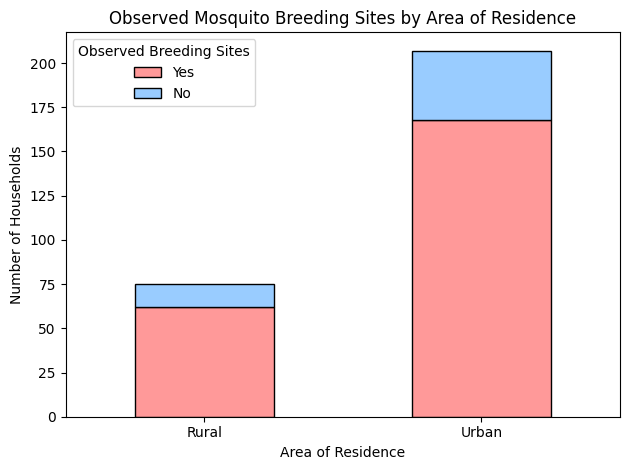

<ipython-input-4-dd867e82f6cc>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=site_data, y='Site', x='Count', palette='Greens_d')


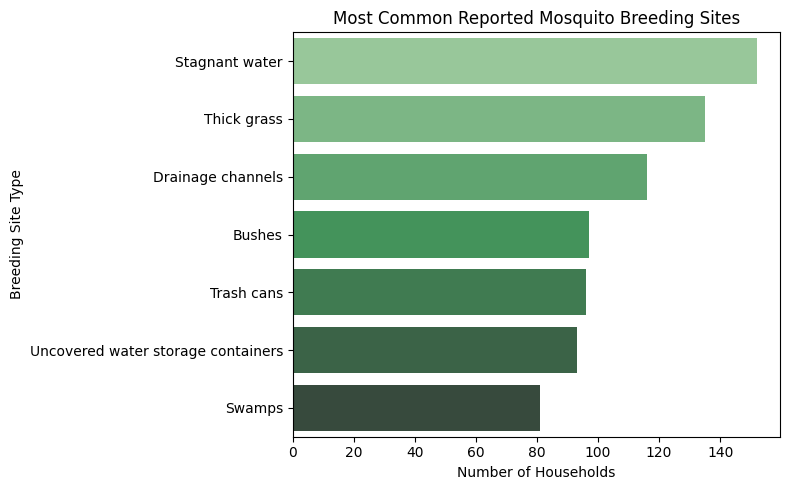

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data: Observed Breeding Sites by Area
obs_data = pd.DataFrame({
    'Area_Residence': ['Rural', 'Urban'],
    'Yes': [62, 168],
    'No': [13, 39]
})
obs_data = obs_data.set_index('Area_Residence')

# Plot 1: Observed breeding sites by area
obs_data[['Yes', 'No']].plot(kind='bar', stacked=True,
                             color=['#FF9999', '#99CCFF'], edgecolor='black')
plt.title("Observed Mosquito Breeding Sites by Area of Residence")
plt.ylabel("Number of Households")
plt.xlabel("Area of Residence")
plt.legend(title='Observed Breeding Sites')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Data: Most Common Breeding Sites
site_data = pd.DataFrame({
    'Site': ['Stagnant water', 'Thick grass', 'Drainage channels',
             'Bushes', 'Trash cans', 'Uncovered water storage containers', 'Swamps'],
    'Count': [152, 135, 116, 97, 96, 93, 81]
})

# Plot 2: Most common breeding sites
plt.figure(figsize=(8, 5))
sns.barplot(data=site_data, y='Site', x='Count', palette='Greens_d')
plt.title("Most Common Reported Mosquito Breeding Sites")
plt.xlabel("Number of Households")
plt.ylabel("Breeding Site Type")
plt.tight_layout()
plt.show()


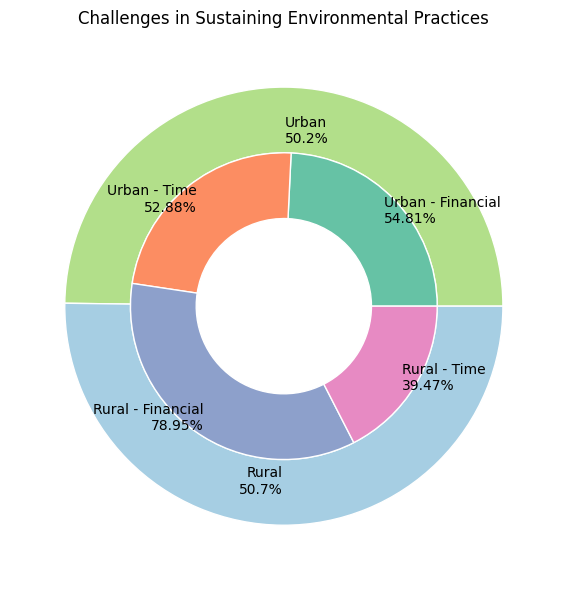

In [ ]:
import matplotlib.pyplot as plt

# Data setup
area_labels = ['Urban', 'Rural']
outer_sizes = [50.24, 50.67]  # Proportion facing challenges
outer_labels = [f"{l}\n{v:.1f}%" for l, v in zip(area_labels, outer_sizes)]

# Inner ring: breakdown of challenges
inner_labels = [
    'Urban - Financial\n54.81%', 'Urban - Time\n52.88%',
    'Rural - Financial\n78.95%', 'Rural - Time\n39.47%'
]
inner_sizes = [54.81, 52.88, 78.95, 39.47]
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

fig, ax = plt.subplots(figsize=(8, 6))

# Outer ring
ax.pie(outer_sizes, radius=1, labels=outer_labels, labeldistance=0.8,
       wedgeprops=dict(width=0.3, edgecolor='w'), colors=['#b2df8a', '#a6cee3'])

# Inner ring
ax.pie(inner_sizes, radius=0.7, labels=inner_labels,
       labeldistance=0.9, wedgeprops=dict(width=0.3, edgecolor='w'), colors=colors)

# Center circle to make it a donut
plt.title("Challenges in Sustaining Environmental Practices")
plt.tight_layout()
plt.show()
